In [1]:
import os
import sys
import datetime
print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

module_dir = os.path.abspath('../src')  # Adjust path as needed
sys.path.append(module_dir)

import time
import glob
import tables as tb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from functools import reduce
import numpy.testing as npt
from operator import itemgetter, attrgetter
%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14
pd.options.display.float_format = '{:.2g}'.format

2024-11-12 16:49:22


In [2]:
from pynext.system_of_units import *

In [3]:
from pynext.Material import PhysicalMaterial
from pynext.PhysicalVolume import PhysicalVolume
from pynext.Shapes import Cylinder, CylinderShell, FlatPlate

In [4]:
from pynext.xetd import Xenon, CXe

In [5]:
from pynext.geometry import draw_cylinder, draw_2cylinder, draw_2cylynder_surface
from pynext.geometry import Cylinder as GCylinder
from pynext.geometry import vectors_spherical
from pynext.geometry import Ray, ray_intersection_with_cylinder
from pynext.geometry import generate_and_transport_gammas_lxe_shell, generate_and_transport_gammas_gxe_shell
from pynext.geometry import generate_and_transport_gammas_lxe_endcaps
from pynext.histograms import h1d

In [6]:
from pynext.CylindricalVessel import  CVD
from pynext.CylindricalVessel import  CylindricalVessel
from pynext.Material import  cu12, cu03
from pynext.activity_functions import  activity_of_CV, print_activity_of_CV

In [7]:
from pynext.energy import gaussian, integrate_gaussian_from_x0
from pynext.energy import plot_gaussians, energy_window_eff, energy_window_fom

# Toy HPXe Detector

- The goal of this exercize is to compute the irreducible background due to the Bi-214 activity in the copper vessel that host the HPXe of NEXT-HD. 

- To this effect we need to know the dimensions of the NEXT-HD vessel and TPC, as well as the activity of Bi-214 in the vessel. NEXT-HD is described in the [NEXT-HD paper](https://arxiv.org/abs/2005.06467). 

- We also need to know the total (photoelectric) interaction cross section in LXe. These data are available from
[NIST](https://physics.nist.gov/cgi-bin/Xcom/xcom3_1) 

- The calculation itself is straight forward.
    - Compute the activity (self-shielded) of Bi-214 in the copper vessel.
    - Obtain the number of gammas with energies 2.448 MeV emitted by Bi-214 (1.5 %, see [here](https://www.nndc.bnl.gov/nudat3/decaysearchdirect.jsp?nuc=214Bi&unc=NDS)
    - Propagate these gammas through NEXT-HD (a cylinder with a mass of 1 ton).
    - Weight the distance they travel by the attenuation factor $e^{-d/L_{att}}$, where $L_{att}$ can be computed from the NIST data.
    - Multiply by the photoelectric fraction.
    - Then, apply the extra handles of NEXT, namely energy resolution and topological signature. NEXT-HD aims to a resolution of 0.5 % FWHM which is good enough to separate Bi-214 from bb0nu at a "moderate" cost in efficiency. NEXT-HD is also capable to distinguish between single electrons (produced by the photoelectric interaction of the Bi-214 gamma) and "double electrons" (produced by bbonu).

- This is just a simple (toy!) calculation, intended to illustrate the basic aspects of the game, all bb0nu experiments have sophisticated background models and hyper-tuned Monte Carlos to make a precise prediction of backgrounds. 
  


## Physics

In [8]:
def mu_vs_e(npdata):
    return npdata[:,0] * MeV, npdata[:,1] * (cm2/g)

In [9]:
def mu_vs_e_phot(npdata):
    return npdata[:,0] * MeV, npdata[:,1] * (cm2/g), npdata[:,2] * (cm2/g)

In [10]:
xenp = np.loadtxt('xe_gamma_att.csv', comments='#', usecols=(0,1))

In [11]:
e, mu_over_rho = mu_vs_e(xenp)

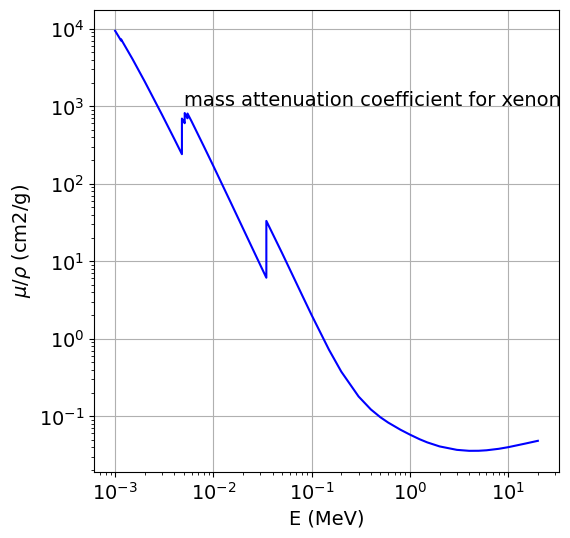

In [12]:
fig = plt.figure(figsize=(6,6))
plt.loglog(e / MeV, mu_over_rho / (cm2/g),'b')
plt.grid(True)
plt.xlabel('E (MeV)')
plt.ylabel(r'$\mu/\rho$ (cm2/g)')
plt.text(0.005, 1000, r'mass attenuation coefficient for xenon')
plt.show()

In [13]:
xphot= np.loadtxt('cross_sections.csv', comments='#')

In [14]:
e, mu_over_rho_phot, mu_over_rho_tot = mu_vs_e_phot(xphot)

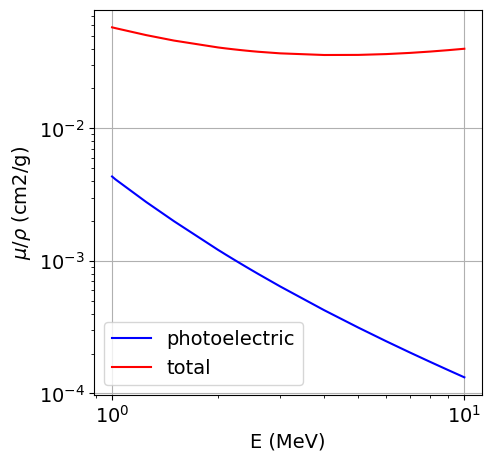

In [15]:
fig = plt.figure(figsize=(5,5))
plt.loglog(e / MeV, mu_over_rho_phot / (cm2/g),'b', label='photoelectric')
plt.loglog(e / MeV, mu_over_rho_tot / (cm2/g),'r', label='total')
plt.grid(True)
plt.xlabel('E (MeV)')
plt.ylabel(r'$\mu/\rho$ (cm2/g)')
plt.legend()
#plt.text(0.005, 1000, r'photoelectric $\mu/\rho$ for xenon')
plt.show()

## Dimensions
- The toy LXe detector that we will consider is an idealisation of nEXO. It consists of a radiopure copper vessel hosting a TPC. The dimensions are taken from nEXO CDR.


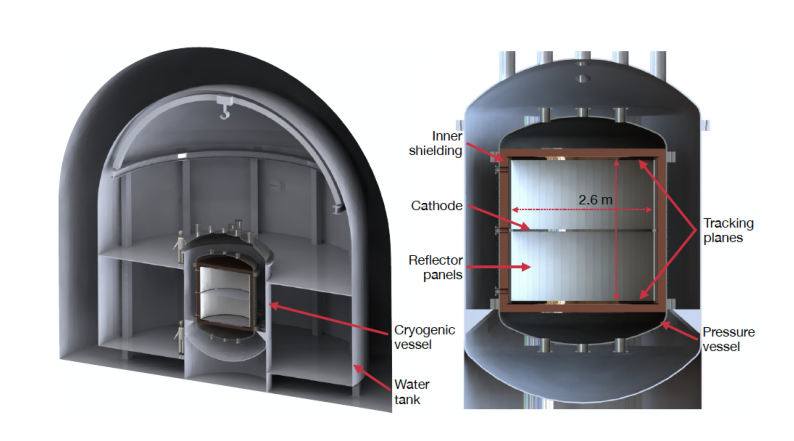

In [16]:
img = mpimg.imread('hd.png')
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()

## Define the TPC

### Xenon

In [17]:
gxe15 = Xenon('xe_1520')
print(gxe15)


        material                                   = xe_1520
        density (rho)                              =    0.09 g/cm3
        mass attenuation coefficient (mu_over_rho) =   0.039 cm2/g
        attenuation coefficient (mu)               =  0.0035 cm^-1
        attenuation length (Latt)                  = 2.9e+02 cm
    


### Xenon Volume


In [18]:
Rg = 125 * cm
Lg = 245 * cm
Dg = 2 * Rg
gxetd = CXe(gxe15, R=Rg, L=Lg, Rb=1*cm, Cb=1*cm, Ab=1*cm)
gxetd


        
        material                                   = xe_1520
        density (rho)                              =    0.09 g/cm3
        mass attenuation coefficient (mu_over_rho) =   0.039 cm2/g
        attenuation coefficient (mu)               =  0.0035 cm^-1
        attenuation length (Latt)                  = 2.9e+02 cm
    
        
        Fiducial Radius =  125.00 cm  xe Radius =  126.00 cm
        Fiducial Length =  245.00 cm  Xe Length =  247.00 cm
        
        Fiducial Volume =   12.03 m3 Xe Volume =   12.32 m3
        Fiducial mass = 1081.17 kg Xe mass = 1107.51 kg
        
        Radial buffer radius =    1.00 cm (E/P ~ 2)
        Cathode buffer thickness =    1.00 cm   (E/P~1)
        Anode buffer thickness =    1.00 cm
        
        Long buffer Volume =    0.19 m3
        Long buffer mass =   17.51 kg
        
        Cathode buffer Volume =    0.05 m3
        Cathode buffer mass =    4.48 kg
        
        Anode buffer Volume =    0.05 m3
        Anod

### Physics Volume
-Define a second GXe volume, the fiducial volume in which one carries on physics (1 ton fiducial)


In [19]:
Rf = 120 *cm
Lf = 240 *cm
Df = 2 * Rg
gxef = CXe(gxe15, R=Rf, L=Lf, Rb=0.1*mm, Cb=0.1*mm, Ab=0.1*mm)
gxef


        
        material                                   = xe_1520
        density (rho)                              =    0.09 g/cm3
        mass attenuation coefficient (mu_over_rho) =   0.039 cm2/g
        attenuation coefficient (mu)               =  0.0035 cm^-1
        attenuation length (Latt)                  = 2.9e+02 cm
    
        
        Fiducial Radius =  120.00 cm  xe Radius =  120.01 cm
        Fiducial Length =  240.00 cm  Xe Length =  240.02 cm
        
        Fiducial Volume =   10.86 m3 Xe Volume =   10.86 m3
        Fiducial mass =  976.08 kg Xe mass =  976.32 kg
        
        Radial buffer radius =    0.01 cm (E/P ~ 2)
        Cathode buffer thickness =    0.01 cm   (E/P~1)
        Anode buffer thickness =    0.01 cm
        
        Long buffer Volume =    0.00 m3
        Long buffer mass =    0.16 kg
        
        Cathode buffer Volume =    0.00 m3
        Cathode buffer mass =    0.04 kg
        
        Anode buffer Volume =    0.00 m3
        Anod

### Attenuation length of Xe at 15 bar

In [20]:
attl = gxetd.xe.material.attenuation_length/mm
print(f"attenuation length in xenon at 15 bar (mm) = {attl}")

attenuation length in xenon at 15 bar (mm) = 2852.1719289238754


### Fraction of gammas that interact in Xenon volume
- We can make a first, rough estimation, computing the fraction of gammas travelling along the longitudinal axis that interact in the physics volume. We can also compute the fraction of gammas travelling along the radial axis that interact in the physics volume.
- Notice, however, that this number overestimates grossly the fraction of interactions in the physics volume, since gammas are emitted in all directions, and a big fraction of them never make it to the physics volume. 

In [21]:
print(f" Fraction of gammas along longitudinal axis that interact in xenon volume ={gxetd.xe.material.absorption_at_qbb(Lg)}") 

 Fraction of gammas along longitudinal axis that interact in xenon volume =0.5764122142219326


In [22]:
print(f" Fraction of gammas along radial axis that interact in xenon volume ={gxetd.xe.material.absorption_at_qbb(Dg)}") 

 Fraction of gammas along radial axis that interact in xenon volume =0.5837732104154458


### Copper vessel

In [23]:
vessel_head_thickness = 120 * mm
vessel_body_thickness = 120 * mm
vessel_length   = Lg + vessel_body_thickness
vessel_diameter = Dg + vessel_head_thickness
vessel_radius = vessel_diameter/2
print(f"GXe copper Vessel: Length = {vessel_length/mm} mm, diameter = {vessel_diameter/mm} mm")
print(f"GXe copper Vessel: thickness body = {vessel_body_thickness/mm} mm, thickness head = {vessel_head_thickness/mm} mm")

GXe copper Vessel: Length = 2570.0 mm, diameter = 2620.0 mm
GXe copper Vessel: thickness body = 120.0 mm, thickness head = 120.0 mm


In [24]:
cugxe = CVD(name    ='GXeCuVessel',
            R       = vessel_radius,
            th_body = vessel_body_thickness,
            L       = vessel_length,
            th_head = vessel_head_thickness)
cugxe

CVD(name='GXeCuVessel', R=1310.0, th_body=120.0, L=2570.0, th_head=120.0)

### We create a cylindrical vessel filled up with cu03, a type of radiopure copper.
- cu03 radiopurity corresponds to 3 muBq/kg, essentially in the limit of waht can be achieved for copper.

In [25]:
pvgxe = CylindricalVessel(name='GXeVessel', material=cu03, cvd=cugxe)
pvgxe


        Cylindrical Vessel:

        ----------------
        name      = GXeCuVessel
        material  = CuBest

        specific activity of material:
        Bi-214    = 3.00e-03 mBq/kg
        Tl-208    = 1.40e-03 mBq/kg

        body:
        R              = 1310.00 mm
        body thickness =  120.00 mm
        head thickness =  120.00 mm
        length         = 2570.00 mm
        surface        = 2.12e+07 mm2
        volume         = 2.65e+09 mm3
        mass           = 23786.08 kg
        activity Bi-214 =   71.36 mBq, self-shielded =   5.38 mBq
        activity Tl-208 =   33.30 mBq, self-shielded =   2.51 mBq
        transmittance   = 1.51e-02

        heads:
        thickness =  120.00 mm
        surface   = 1.08e+07 mm2
        volume    = 1.29e+09 mm3
        mass      = 11593.42 kg
        activity Bi-214 =   17.39 mBq, self-shielded =   1.31 mBq
        activity Tl-208 =    8.12 mBq, self-shielded =   0.61 mBq
        transmittance   = 1.51e-02

        

### Activity of Cu vessel
- Most of the activity is self-shielded, so that the remaining activity is a small fraction, larger for Bi-214 than for Tl-208 and larger in the radial direction than in the axial direction where self-shield is larger.
- It follows that the dominant effect for radioactivity will be Bi-214 gammas shot from the body of the vessel.
- Notice also that Bi-214 gammas are ~10 keV of Xe-137 Qbb, and thus with the resolution of LXe cannot be separated at all using resolution

In [26]:
cs_activity = activity_of_CV('activity of LXe PV (self-shielded)', pvgxe)
print_activity_of_CV(cs_activity, unit='mBq')


    activity 		 activity of LXe PV (self-shielded)
    body  (Bi-214) 	    5.38 mBq
    head  (Bi-214) 	    1.31 mBq
    total (Bi-214) 	    6.69 mBq
    body  (Tl-208) 	    2.51 mBq
    head  (Tl-208) 	    0.61 mBq
    total (Tl-208) 	    3.12 mBq
    


In [27]:
cs_body_activity_bi214_Bq = cs_activity.body_bi214/Bq
cs_head_activity_bi214_Bq = cs_activity.head_bi214/Bq

## Generation and transport in GXe toy detector
- Our next goal is to estimate the fraction of gammas of 2.5 MeV (e.g, Bi-214) emitted from the copper vessel that will make it into the physics volume. This gammas represent an irreducible background, since they cannot be separated from signal (they produce a photolectric interaction with the same energy than the Qbb decay)
- This is simply an acceptance calculation. We will do it defining a volume (cshell) that represents the copper vessel and a second volume (cphys) that represents the LXe volume in which we want to do physics. We then shoot uniformly gammas from chsell in an angle of 2pi (since the activity that we have computed is already shielded, and includes those gammas that are shot backwards) and compute how many of them reach cphys.
- We use GGylinder, which represents a Geometrical-Cylinder (e.g, in space). All dimensions assumed to be in mm
- Notice that the dimensions of the shell cylinder correspond to the dimensions of the TPC, not to the cupper vessel, since we have already computed the attenuation of the copper.

In [28]:
cshell =GCylinder(Rg, zmin = 0, zmax = Lg)
cshell

Cylinder(r=1250.0, zmin=0, zmax=2450.0)

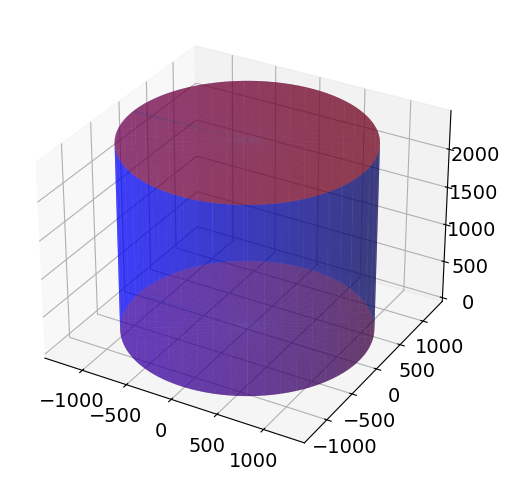

In [29]:
draw_cylinder(cshell, alpha=0.5, figsize=(6,6))

#### Transport in the Barrel

c1 =Cylinder(r=1250.0, zmin=0, zmax=2450.0)


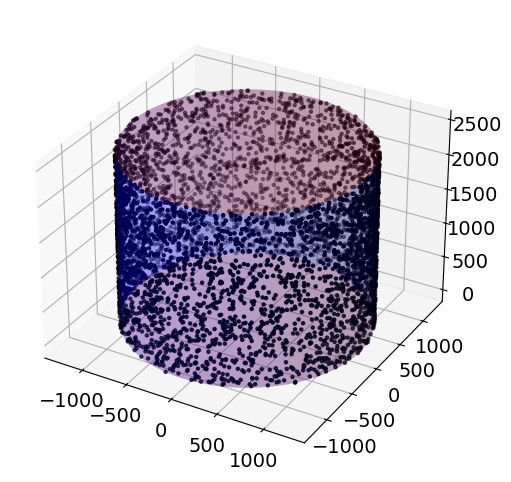

In [30]:
WF, DST = generate_and_transport_gammas_gxe_shell(cshell, 
                                       nphotons=5000, ndx= 100, 
                                       solidAngle="half",
                                       verbose=1, drawRays=False, scale=300)

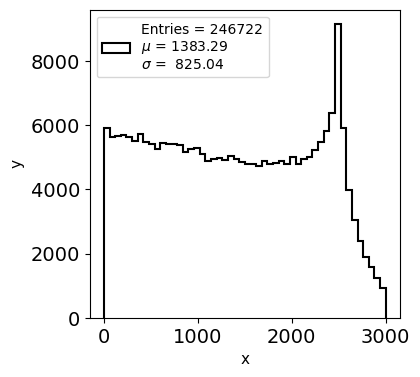

In [31]:
n, b, mu, std = h1d(DST, 50, (0, 3000), figsize=(4,4)) 

In [32]:
dx_barrel = mu
print(f"average distance travelled by interacting gammas = {dx_barrel} mm")

average distance travelled by interacting gammas = 1383.290034339792 mm


In [33]:
print(f"average attenuation, exponential law = {np.exp(-dx_barrel/attl)}")

average attenuation, exponential law = 0.6157000788866279


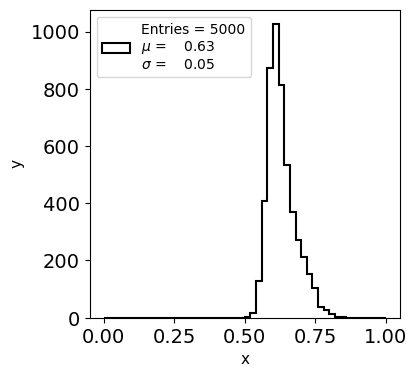

In [34]:
n, b, mu, std = h1d(WF, 50, (0, 1.0), figsize=(4,4)) 

In [35]:
w_barrel = mu
print(f"mean weight in barrel = {w_barrel:7.3g}")

mean weight in barrel =   0.632


#### Transport end-caps

-Since the detector is symmetric we can take the same value than in the barrel

In [36]:
w_ecap = mu
print(f"mean weight in end-caps = {w_ecap:7.2g}")

mean weight in end-caps =    0.63


## Energy resolution
-In the case of a GXe detector, energy resolution is relevant. NEXT achieves a resolution better than < 1% FWHM and the DBDM prototype has achieved a resolution of 0.5 % FWHM. [NEXT-HD paper](https://arxiv.org/abs/2005.06467) assumes that 0.5 % FWHM can be achieved in a large detector. Let's use this number to compute how much separation can be achieved between the signal and the Bi-214 gamma.

In [37]:
# GXe
mean1 = 2447
mean2 = 2457
sigma_x = 0.005/2.3  #0.5 % FWHM
sigma1 = mean1 * sigma_x
sigma2 = mean2 * sigma_x
print(f"sigma resolution around Qbb peak  = {sigma1} keV")

sigma resolution around Qbb peak  = 5.319565217391305 keV


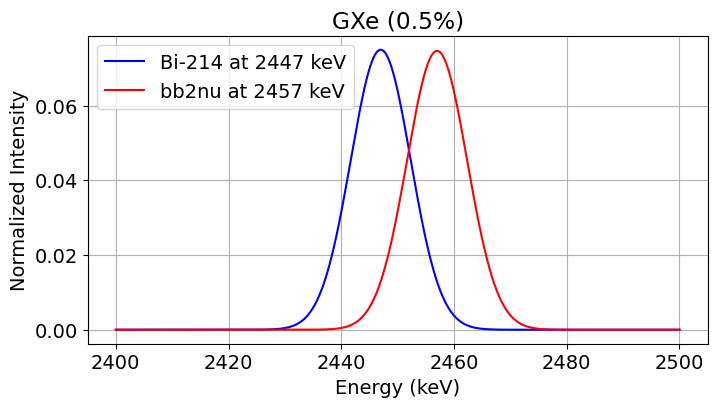

In [38]:
plot_gaussians(mean1, mean2, sigma1, sigma2, "GXe (0.5%)")

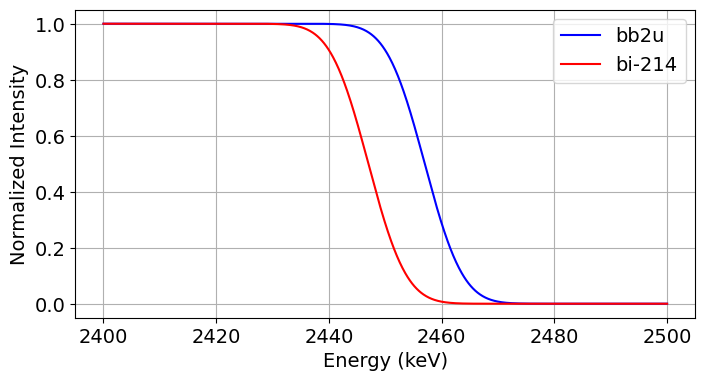

In [39]:
eg = np.linspace(2400, 2500, 1000)
fbb = np.array([integrate_gaussian_from_x0(mean2, sigma2, x0) for x0 in eg])
fbi = np.array([integrate_gaussian_from_x0(mean1, sigma1, x0) for x0 in eg])
energy_window_eff(eg, fbb, fbi)

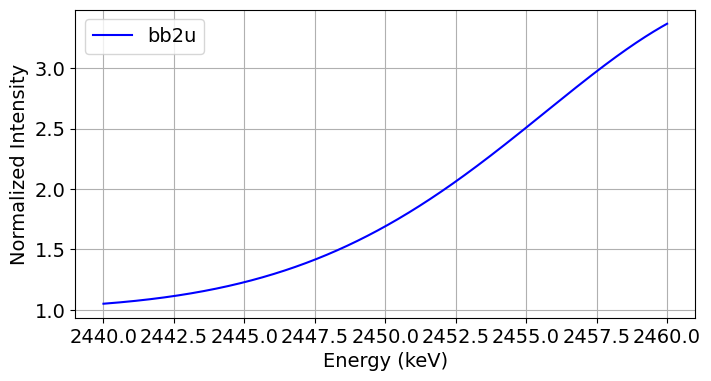

In [40]:
eg = np.linspace(2440, 2460, 1000)
fbb = np.array([integrate_gaussian_from_x0(mean2, sigma2, x0) for x0 in eg])
fbi = np.array([integrate_gaussian_from_x0(mean1, sigma1, x0) for x0 in eg])
energy_window_fom(eg, fbb, fbi)

In [41]:
xc = 2457
ebb =integrate_gaussian_from_x0(mean2, sigma2, xc) 
ebi =integrate_gaussian_from_x0(mean1, sigma1, xc) 
print(f"signal efficiency in window > {xc}: {ebb}")
print(f"Bi-214 efficiency in window > {xc}: {ebi}")

signal efficiency in window > 2457: 0.5000000000000006
Bi-214 efficiency in window > 2457: 0.030064065555605698


## Topological signal

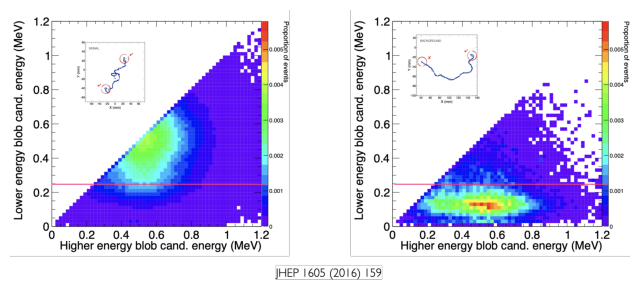

In [104]:
plt.figure(figsize=(8, 6))
plt.subplot(1, 1, 1)
img = mpimg.imread('../latex/topoNew.png')
plt.imshow(img)
plt.axis('off')  # Hide axes
#plt.subplot(1, 2, 2)
#img2 = mpimg.imread('sensim_10mm_signal_vs_background_curve.png')
#plt.imshow(img2)
#plt.axis('off')  # Hide axes
plt.show()

In [47]:
topo = np.loadtxt('top_sel.csv', comments='#')

In [76]:
topo

array([[1.000e+00, 0.000e+00],
       [1.000e+00, 1.000e-04],
       [1.000e+00, 9.740e-03],
       ...,
       [2.151e-02, 9.999e-01],
       [2.151e-02, 1.000e+00],
       [0.000e+00, 1.000e+00]])

In [82]:
bibr = topo[:,1] 
bbeff = topo[:,0]
indx = 500


In [85]:
def plot_topology(bibr, bbeff, indx):
    etbi = 1 - bibr[indx:-1]
    etbb = bbeff[indx:-1]

    plt.figure(figsize=(8, 4))
    plt.plot(etbi, etbb, color='blue')
   
    plt.xlabel('Bi fraction ')
    plt.ylabel('Signal fraction')
    plt.grid()
    plt.show()

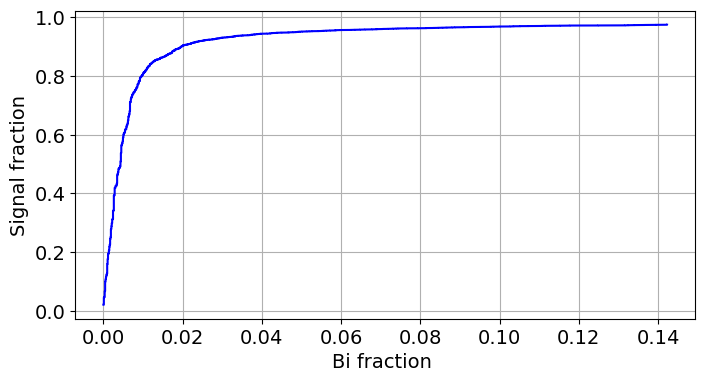

In [87]:
plot_topology(bibr, bbeff, 700)

In [96]:
for i, e in enumerate(bbeff):
    if bbeff[i] > 0.790 and bbeff[i] < 0.810:
        print(i, bbeff[i])

1549 0.80931
1550 0.80931
1551 0.8063
1552 0.8063
1553 0.8038
1554 0.8038
1555 0.80193
1556 0.80193
1557 0.79985
1558 0.79985
1559 0.7984
1560 0.7984
1561 0.79559
1562 0.79559
1563 0.79539
1564 0.79539
1565 0.793
1566 0.793


In [100]:
etbi = 1 - bibr[1556]
etbb = bbeff[1556]
print(f"Topology efficiency for the signal = {etbb}")
print(f"Topology efficiency for Bi-214 = {etbi}")

Topology efficiency for the signal = 0.80193
Topology efficiency for Bi-214 = 0.009739999999999971


## Background of Bi-214 due to copper vessel. 

$$ R_{\gamma(2448 keV)}^{{}^{214}Bi} = A^{{}^{214}Bi} {\rm [Bq]} \times BR^{{}^{214}Bi}_{\gamma(2448 keV)} = 1.55 \cdot 10^{-3} {\rm [cts/sec]} \times 1.5 \cdot 10^{-2}$$

$$ N_{\gamma(2448 keV)}^{{}^{214}Bi} {\rm ~1 year} = R_{\gamma(2448 keV)}^{{}^{214}Bi} \times 3.1 \cdot 10^7 $$

$$ I_{\gamma(2448 keV)}^{{}^{214}Bi} {\rm ~ year/ROI/ton} = N_{\gamma(2448 keV)}^{{}^{214}Bi} \times f_{\gamma(2448 keV)}^{ROI} $$

$$ Phot_{\gamma(2448 keV)}^{{}^{214}Bi} {\rm ~ year/ROI/ton} = I_{\gamma(2448 keV)}^{{}^{214}Bi} \times 
\frac{\sigma_{phot}}{\sigma_{total}}(2448 keV) $$

$$ Sel_{\gamma(2448 keV)}^{{}^{214}Bi} {\rm ~ year/ROI/ton} = Phot_{\gamma(2448 keV)}^{{}^{214}Bi} \times 
\epsilon_{ROI} \times \epsilon_{topo} $$

### Bi-214 gamma (2448 keV)


In [101]:
brg = 1.5e-2           # BR of 2448 keV gamma
xpg = xphot[10][1]     # Photoelectric cross section at 2448 keV
xtg = xphot[10][2]     # total cross section at 2448 keV
xpe = xpg/xtg          # ratio photoelectric/total 
print(f"BR of 2448 keV gamma= {brg}")
print(f"Ratio of photoelectric to total cross section = {xpe}")

BR of 2448 keV gamma= 0.015
Ratio of photoelectric to total cross section = 0.02218381775333857


### Backgrounds in the Body

In [102]:
rg = cs_body_activity_bi214_Bq * brg
ng = rg * year/second
ig = ng * w_barrel
pg = ig * xpe
ps = pg * ebi * etbi
print(f"rate of gammas of 2448 keV emitted by copper (self-shielded) = {rg}")
print(f"number of gammas of 2448 keV emitted by copper (one year) = {ng}")
print(f"number of gammas of 2448 keV interacting in fiducial volume = {ig}")
print(f"number of gammas of 2448 keV making a photoelectric in fiducial volume = {pg}")
print(f"number of gammas of 2448 keV selected = {ps}")

rate of gammas of 2448 keV emitted by copper (self-shielded) = 8.063564944233994e-05
number of gammas of 2448 keV emitted by copper (one year) = 2542.9258408136325
number of gammas of 2448 keV interacting in fiducial volume = 1606.0387747902103
number of gammas of 2448 keV making a photoelectric in fiducial volume = 35.62807148474119
number of gammas of 2448 keV selected = 0.010432754351418985


### Background due to end-caps is similar